<H1>Explore SA-GAWLER CHALLENGE


In recent years, researches on processing geochemical data, identifying geochemical anomalies using machine learning and data science has made important progress. This notebook intents a kick start for such an initiative in finding unexplored resources of Southern Australia.
<blockquote><H5>"The present is the key to past" - Sir Charles Lyell</H5></blockquote>
 
This notebook focuses on the basic pre-processing of the available data that are required for the challenge. In the Gawler challenge, we will be using two machine learning models to predict the commodity present at a particular location. In this notebook, we will be discussing the data preprocessing of the preliminary model which is used to predict the presence of minerals at a particular location. This is performed using the data collected from the SARIG Data Package. 
<hr>

<H2>   Data Preparation

Importing Necessary libraries

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from tqdm import trange
from collections import Counter
import warnings
warnings.filterwarnings("ignore") 

The SARIG data package contains information including details of <b>Mineral Deposits, Drillholes, Rock Samples & Analysis and Field Observations</b>. 
Because this data is for the preliminary model, we will only be using data associated with Mineral deposits.
<hr>
Extracting all file names related to Mineral Deposits (sarig_md):

In [26]:
folder_name = r"data\SARIG_Data_Package\\"
# Get names of Mineral Deposit csv files
md_files_names = [file_name for file_name in os.listdir(folder_name) if file_name.startswith('sarig_md')]
print(md_files_names)   

['sarig_md_commodity_exp.csv', 'sarig_md_details_exp.csv', 'sarig_md_mineralogy_exp.csv', 'sarig_md_reference_exp.csv', 'sarig_md_zone_hr_lith_exp.csv', 'sarig_md_zone_lith_exp.csv']


In [27]:
# Get the shape of Mineral Deposit csv files
for file in md_files_names:
    df = pd.read_csv(os.path.join(folder_name + file), encoding = "ISO-8859-1")
    print(df.shape)

(11017, 14)
(8694, 28)
(16010, 17)
(14680, 19)
(4398, 19)
(8651, 20)


<H2>Loading Data

<hr>
Loading Mineral Deposits data to different dataframes

In [28]:
# Load csv Data
md_details = pd.read_csv(os.path.join(folder_name + 'sarig_md_details_exp.csv'), encoding = "ISO-8859-1")
md_commodity = pd.read_csv(os.path.join(folder_name + 'sarig_md_commodity_exp.csv'), encoding = "ISO-8859-1")
md_mineralogy = pd.read_csv(os.path.join(folder_name + 'sarig_md_mineralogy_exp.csv'), encoding = "ISO-8859-1")
md_zone_hr_lith = pd.read_csv(os.path.join(folder_name + 'sarig_md_zone_hr_lith_exp.csv'), encoding = "ISO-8859-1")
md_zone_lith = pd.read_csv(os.path.join(folder_name + 'sarig_md_zone_lith_exp.csv'), encoding = "ISO-8859-1")

<H2>Exploratory Data Analysis of Mineral Deposit Datasets

Exploratory Data Analysis is a philosophical and artistical approach to gauge every nuance from the data at an early encounter. We will be achieving this by using various visual methods. For ease of data visualisation, we have used Tableau Desktop, one of the most popular visualisation tool.
The below figure shows the top commodities in the details dataset
![d](Figures/Bar_Chart_Commodities_1.png "Commodities")
    <blockquote> We can clearly see that the variable commodity contains comma separated mineral names in a single cell for various records. In data preprocessing step we will split commas separated values into different rows</blockquote> 
 
<hr>
The geographical mineral distribution of commodities are generated below. 

![d](Figures/map_commodities_full.png "Commodities_map")

   <blockquote> We can clearly see that the distribution contains information outside of Gawler Region. In data cleaning step we will only select data from Gawler region so that the model accuracy is improved</blockquote> 
   
   
<hr>
The number of records of mineral ore is generated below.

![d](Figures/bar_minerology_ore.png "Commodities_map")


<blockquote> We can clearly see that the data contains large number of null values. In data cleaning step, we will remove large null values</blockquote> 


<H2> Data Cleaning
<hr>
<h3><i>1) Feature selection</i></h3>
<br>
Now we eliminate the highly correlated columns and keep only relevant ones. (For example, GDA94 and GDA2020 columns can be called as redundant)


In [29]:
# Select relevant columns
md_details = md_details[['MINERAL_DEPOSIT_NO', 'DISCOVERY_YEAR', 'COMMODITIES', 'MINEROLOGY_ORE',
                         'MINEROLOGY_GANGUE', 'SITE_NO', 'ZONE_GDA2020', 'LONGITUDE_GDA2020', 'LATITUDE_GDA2020', 
                         'SURVEY_METHOD']]
md_details = md_details.fillna('-')


Here we display the data in the map to get a visual understanding of the data

In [30]:
md_details['LATITUDE_GDA2020'] = md_details['LATITUDE_GDA2020'].apply(lambda x:round(x,2))
md_details['LONGITUDE_GDA2020'] = md_details['LONGITUDE_GDA2020'].apply(lambda x:round(x,2))
md_density = md_details.groupby(['LATITUDE_GDA2020','LONGITUDE_GDA2020'])['MINERAL_DEPOSIT_NO'].count().reset_index()

One can cleary see that the dataset contains information of area outside Gawler region. Reducing the area to Galwer region can help in creating a better quality model.

<hr>
<h3><i>2) Removing Invalid Data</i></h3>
<br>
Variables containing a large number of Null value can deplete the model quality. So, we will be performing an initial cleanup to remove columns having a greater percentage of irrelevant data as discussed in the EDA.

In [31]:
#Function to clean and drop columns with large missing values
def clean_df(df):
    # Remove duplicate row
    df = df.drop_duplicates()

    # Drop columns with more than 75% missing values
    for col in df.columns:
        if df[col].isna().sum() > (0.75 * len(df)):
            df = df.drop(col, axis=1)
    return df

In [32]:

# Clean Data and dropping columns with large  missing values
md_commodity = clean_df(md_commodity)
md_mineralogy = clean_df(md_mineralogy)
md_zone_hr_lith = clean_df(md_zone_hr_lith)
md_zone_lith = clean_df(md_zone_lith)

<hr>
<h3><i>3) Limiting data to Gawler region</i></h3>
<br>
Now we extract the data from Gawler region.[X(-35.1,-26.79),Y(131,148.59)]

In [33]:
south_aus_coord = {'lat': (-35.1, -26.79),
                   'long': (131, 138.59)}

md_details = md_details[(md_details['LATITUDE_GDA2020'] > south_aus_coord['lat'][0]) &\
                (md_details['LATITUDE_GDA2020'] < south_aus_coord['lat'][1])]
md_details = md_details[(md_details['LONGITUDE_GDA2020'] > south_aus_coord['long'][0]) &\
                (md_details['LONGITUDE_GDA2020'] < south_aus_coord['long'][1])]
md_density_sa = md_details.groupby(['LATITUDE_GDA2020','LONGITUDE_GDA2020'])['MINERAL_DEPOSIT_NO'].\
                count().reset_index()

In [34]:
# Distribution of Mineral Deposits
m = folium.Map(location=[md_density_sa['LATITUDE_GDA2020'].mean(),
                         md_density_sa['LONGITUDE_GDA2020'].mean()], zoom_start=4)
 
for i in trange(0,len(md_density_sa)):
    folium.Circle(
      location=[md_density_sa.iloc[i]['LATITUDE_GDA2020'], md_density_sa.iloc[i]['LONGITUDE_GDA2020']],
      radius=md_density_sa.iloc[i]['MINERAL_DEPOSIT_NO']*1000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
m

100%|████████████████████████████████████| 2730/2730 [00:02<00:00, 1095.87it/s]



![d](Figures/map_commodities_gawler.png "Commodities_map")

<H2>Processing

From EDA analysis we found that commodities/minerology_ore/minerology_gangue column contains multiple elements. To do proper prediction we need to split them into different rows. 

In [35]:

md_details['COMMODITIES'] = md_details['COMMODITIES'].apply(lambda x:x.split(',  '))
md_details['MINEROLOGY_ORE'] = md_details['MINEROLOGY_ORE'].apply(lambda x:x.split(',  '))
md_details['MINEROLOGY_GANGUE'] = md_details['MINEROLOGY_GANGUE'].apply(lambda x:x.split(',  '))
md_details.head()

,MINERAL_DEPOSIT_NO,DISCOVERY_YEAR,COMMODITIES,MINEROLOGY_ORE,MINEROLOGY_GANGUE,SITE_NO,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,SURVEY_METHOD
0,17,1899,[Copper],"[Bornite, Chalcocite, Chalcopyrite, Malachite]","[Quartz, Siderite]",210457,54,138.40,-30.88,Google Earth image
1,21,1899,[Copper],[Malachite],"[Barite, Calcite, Iron oxide (non specific), Q...",210458,54,138.40,-30.87,Google Earth image
2,33,1987,[Iron],[Magnetite],"[Feldspar, Quartz]",209556,52,131.92,-30.63,"Sourced from documents (PLANS, ENV, RB,etc)"
4,35,1970,[Copper],[Cuprite],[-],209575,53,133.23,-26.94,Google Earth image
7,38,1903,[Gold],[Gold],"[Pyrite, Quartz]",209594,53,133.50,-26.93,Google Earth image


The top ten commodities are displayed using a bar graph. This clearly shows that Copper and Gold are the most abundant commodities in the region

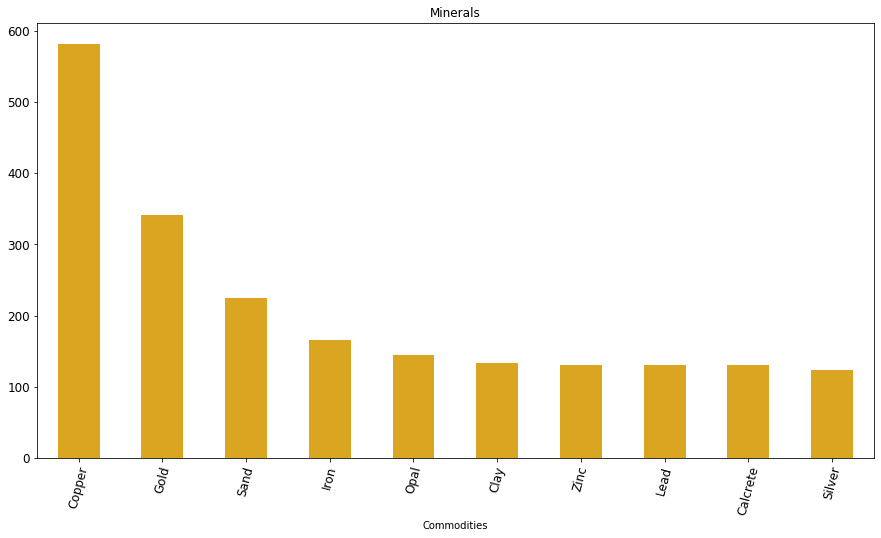

In [36]:
commodities = dict(Counter(md_details['COMMODITIES'].sum()))
commodities_df = pd.DataFrame({'Commodities':list(commodities.keys()), 
                               'Count':list(commodities.values())}).set_index('Commodities').sort_values('Count',
                                                                                                         ascending=False)

# Top 10 Mineral commodities found
commodities_df[:10].plot(kind='bar', figsize=(15,8), title='Minerals', color='goldenrod', rot=75, fontsize=12, legend=False)

Combining md_details, md_commodity and md_minerology data¶


In [37]:
# Select relevant columns
md_commodity = md_commodity[['MINERAL_DEPOSIT_NO', 'COMMODITY_NAME', 'SIGNIFICANCE']]
md_mineralogy = md_mineralogy[['MINERAL_DEPOSIT_NO', 'MINERAL', 'RELATIVE_ABUNDANCE_CODE',
                               'MINERAL_TYPE', 'WEATHERING_PRODUCT']]

# Merge md_details, md_commodity and md_minerology data
md_detail_comm = md_details.merge(md_commodity, on='MINERAL_DEPOSIT_NO', how='left').\
                 drop(['COMMODITIES'], axis=1)
md_detail_comm_min = md_detail_comm.merge(md_mineralogy, on='MINERAL_DEPOSIT_NO', how='left').\
                     drop(['MINEROLOGY_ORE', 'MINEROLOGY_GANGUE'], axis=1, )
md_detail_comm_min.head()

,MINERAL_DEPOSIT_NO,DISCOVERY_YEAR,SITE_NO,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,SURVEY_METHOD,COMMODITY_NAME,SIGNIFICANCE,MINERAL,RELATIVE_ABUNDANCE_CODE,MINERAL_TYPE,WEATHERING_PRODUCT
0,17,1899,210457,54,138.4,-30.88,Google Earth image,Copper,MAJOR,Bornite,TRACE,ORE,N
1,17,1899,210457,54,138.4,-30.88,Google Earth image,Copper,MAJOR,Chalcocite,TRACE,ORE,Y
2,17,1899,210457,54,138.4,-30.88,Google Earth image,Copper,MAJOR,Chalcopyrite,RARE,ORE,N
3,17,1899,210457,54,138.4,-30.88,Google Earth image,Copper,MAJOR,Malachite,MINOR,ORE,Y
4,17,1899,210457,54,138.4,-30.88,Google Earth image,Copper,MAJOR,Quartz,MAJOR,GANGUE,N


<br>Separating the 10 commodity data into different csv files so that we can separately create classification models for each commodity

In [38]:
top_10 = list(md_commodity['COMMODITY_NAME'].value_counts()[:10].index.values)

comm_dict = {}
cleaned_notebooks_path='../cleaned_datasets/'
for comm in top_10:
    comm_csv_true = md_detail_comm_min[md_detail_comm_min['COMMODITY_NAME'] == comm]
    comm_csv_false = md_detail_comm_min[md_detail_comm_min['COMMODITY_NAME'] != comm]
    comm_csv_true['Is_present'], comm_csv_false['Is_present'] = 1, 0
    comm_csv = comm_csv_true.append(comm_csv_false)
    comm_csv = comm_csv.drop_duplicates(['MINERAL_DEPOSIT_NO', 'LONGITUDE_GDA2020',
                                         'LATITUDE_GDA2020'])
    comm_dict[comm] = comm_csv
    comm_csv.to_csv(cleaned_notebooks_path+comm+'.csv')


We here explore the newly created Gold data set

It is clear from the below figure that Gold was found in 1519 locations

![Gold Data](Figures/Gold%20Bar%20graph.png "Gold Data")

The map below shows the geo locations in which gold was found and not found

![gold Map](Figures/map%20gold.png "Gold Data")

By using this location data of each commodities, we can create a classifier model using the top 10 commodities. These models can be used to predict whether there is a potential for a mineral in a particular location based on historic data. The model created from the above data will completely be based on mineral deposits. This model can be used to do preliminary test for minerals at a particular location.
Using other data like Hydrochemical data, we could create a more accurate model which requires input from physical site. This model can be applied after doing the preliminary test. 

The 10 commodity data is stored in 10 csv files in the cleaned_datasets



<H2>Additional Analysis

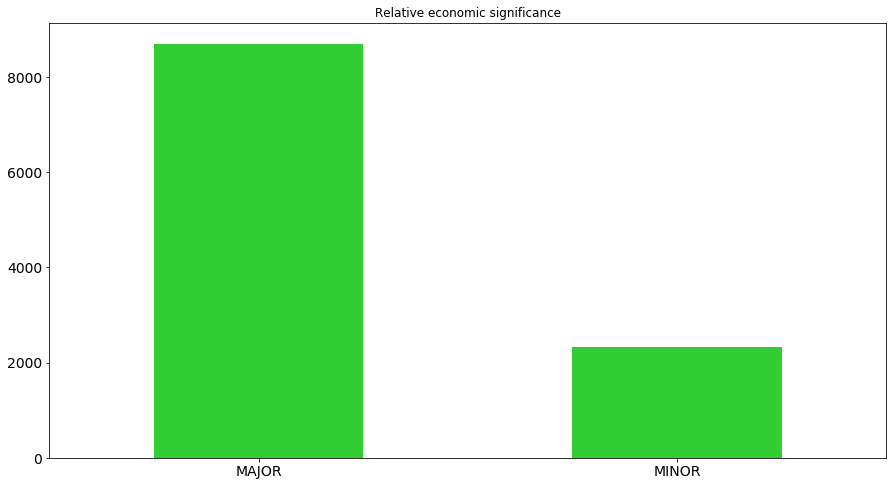

In [39]:
md_commodity = md_commodity[['MINERAL_DEPOSIT_NO', 'COMMODITY_NAME', 'SIGNIFICANCE']]

# Relative economic significance of the commodity to the mineral deposit
md_commodity['SIGNIFICANCE'].value_counts().plot(kind='bar', figsize=(15,8), title='Relative economic significance',
                                                 color='limegreen', rot=0, fontsize=14)

In [40]:
ore = dict(Counter(md_details['MINEROLOGY_ORE'].sum()))
ore_df = pd.DataFrame({'MINEROLOGY ORE':list(ore.keys()), 
                       'Count':list(ore.values())}).set_index('MINEROLOGY ORE').sort_values('Count', ascending=False)

gangue = dict(Counter(md_details['MINEROLOGY_GANGUE'].sum()))
gangue_df = pd.DataFrame({'MINEROLOGY GANGUE':list(gangue.keys()), 
                          'Count':list(gangue.values())}).set_index('MINEROLOGY GANGUE').sort_values('Count', ascending=False)

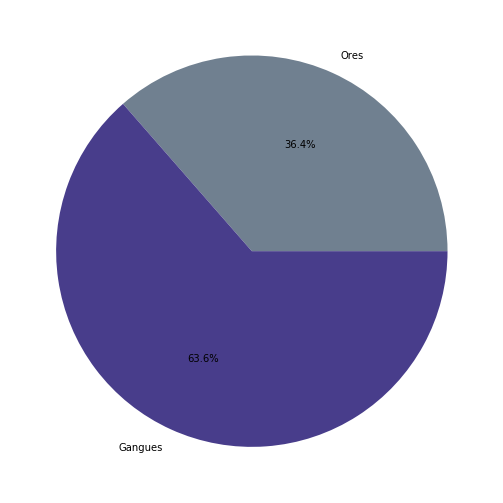

In [41]:
gangue_count = ore['-']
ore_count = gangue['-']

plt.figure(figsize=(15,9))
plt.pie([gangue_count, ore_count], labels=['Ores', 'Gangues'], colors=['slategrey', 'darkslateblue'], autopct='%1.1f%%',)
plt.show()

39.1% of the mineral types found in mineral deposits are Ores and the remaining 60.9% are gangues

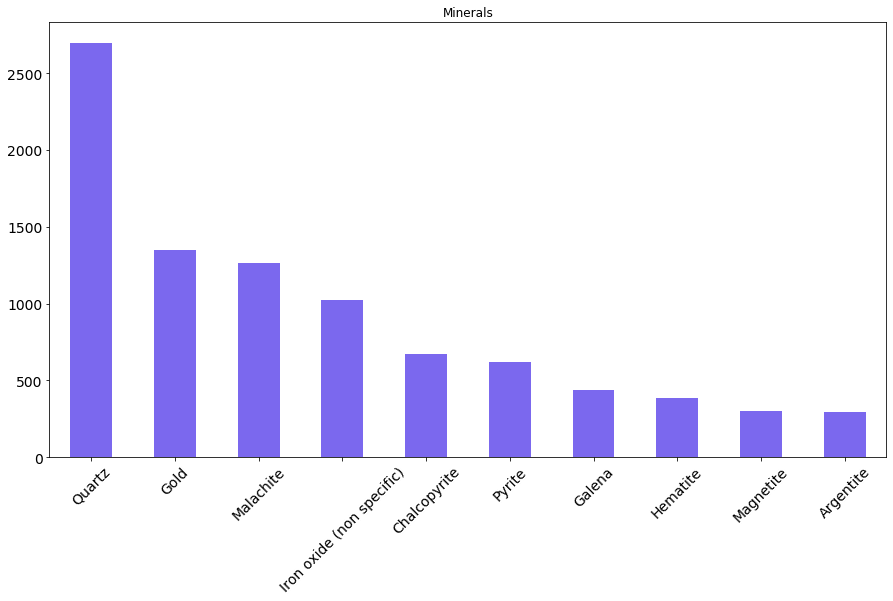

In [42]:
md_mineralogy = md_mineralogy[['MINERAL_DEPOSIT_NO', 'MINERAL', 'RELATIVE_ABUNDANCE_CODE', 'WEATHERING_PRODUCT']]

# Top 10 Minerals found
# Relative economic significance of the commodity to the mineral deposit
md_mineralogy['MINERAL'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='mediumslateblue', rot=45, fontsize=14)

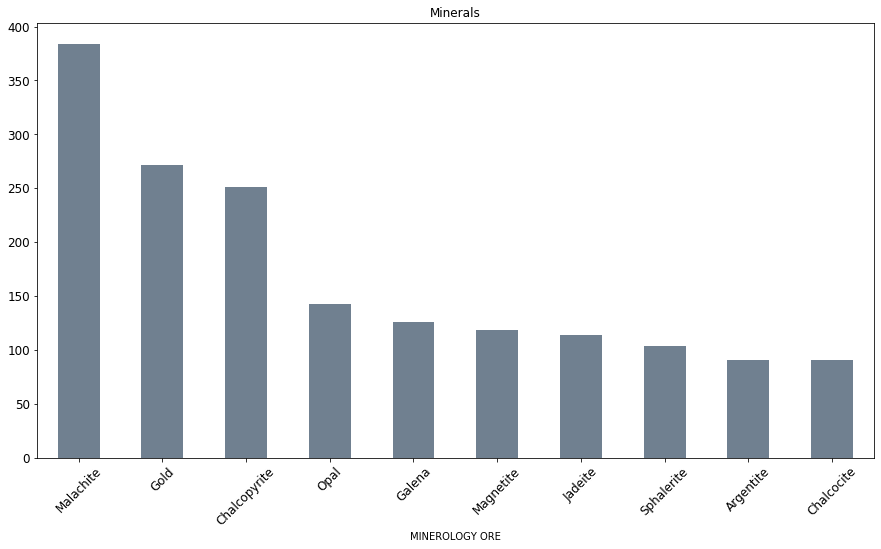

In [43]:
# Top 10 Minerals found in Ores
# There is no data for 3382 rows
ore_df[1:11].plot(kind='bar', figsize=(15,8), title='Minerals', color='slategrey', rot=45, fontsize=12, legend=False)

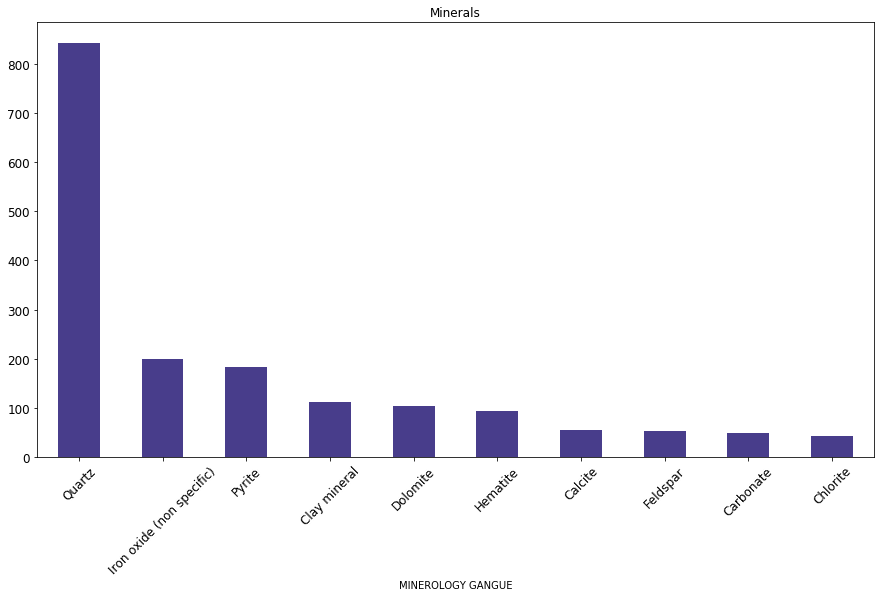

In [44]:
# Top 10 Minerals found in Gangues
# There is no data for 5273 rows
gangue_df[1:11].plot(kind='bar', figsize=(15,8), title='Minerals', color='darkslateblue', rot=45, fontsize=12, legend=False)

**Trace**    - **1-4 % by volume**  
**Minor**    - **5-29 % by volume**  
**Rare**     - **<1 % by volume**  
**Abundant** - **>70 % by volume**  
**Major**    - **30- 70 % by volume**  

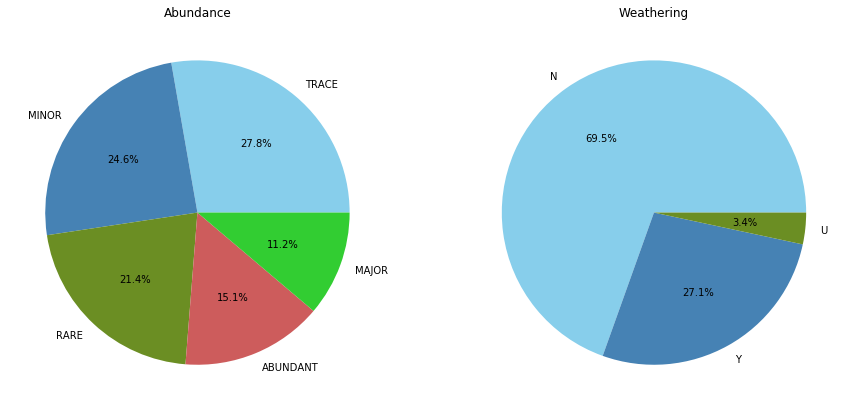

In [45]:
# Abundance of Minerals
abundance_df = md_mineralogy['RELATIVE_ABUNDANCE_CODE'].value_counts()

plt.figure(figsize=(15,16))
plt.subplot(221)
plt.pie(abundance_df.values, labels=abundance_df.index.values, colors=['skyblue', 'steelblue', 'olivedrab', 'indianred',
                                                                    'limegreen'], autopct='%1.1f%%')
plt.title('Abundance')

# Whether mineral is a product of weathering
weathering_df = md_mineralogy['WEATHERING_PRODUCT'].value_counts()

plt.subplot(222)
plt.pie(weathering_df.values, labels=weathering_df.index.values, colors=['skyblue', 'steelblue', 'olivedrab'],
        autopct='%1.1f%%')
plt.title('Weathering')

plt.show()

In [46]:
md_zone_lith = md_zone_lith[['MINERAL_DEPOSIT_NO', 'LITHOLOGY', 'HR_STRAT_UNIT']]
md_zone_hr_lith = md_zone_hr_lith[['MINERAL_DEPOSIT_NO', 'LITHOLOGY', 'HR_STRAT_UNIT']]

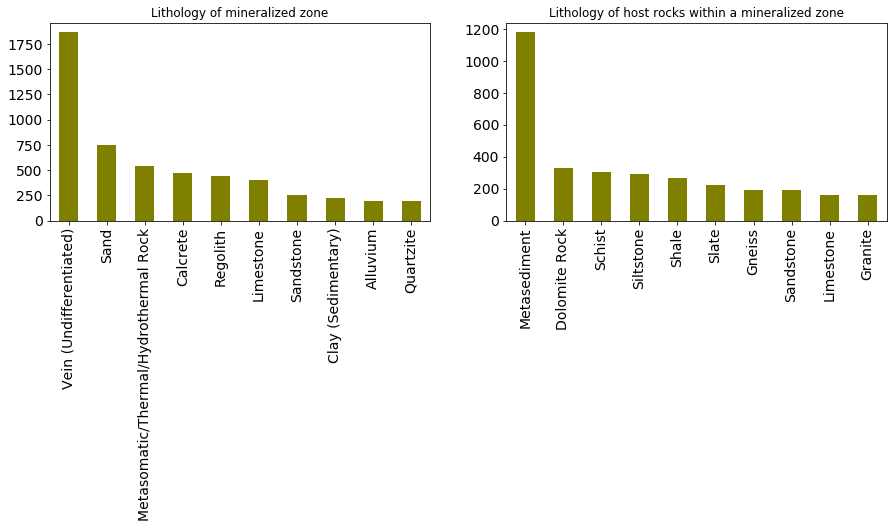

In [47]:


# Lithology of mineralized zone
plt.figure(figsize=(15,16))
plt.subplot(221)
md_zone_lith['LITHOLOGY'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='olive', rot=90, fontsize=14)
plt.title('Lithology of mineralized zone')

# Lithology of host rocks within a mineralized zone
plt.subplot(222)
md_zone_hr_lith['LITHOLOGY'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='olive', rot=90, fontsize=14)
plt.title('Lithology of host rocks within a mineralized zone')

plt.show()

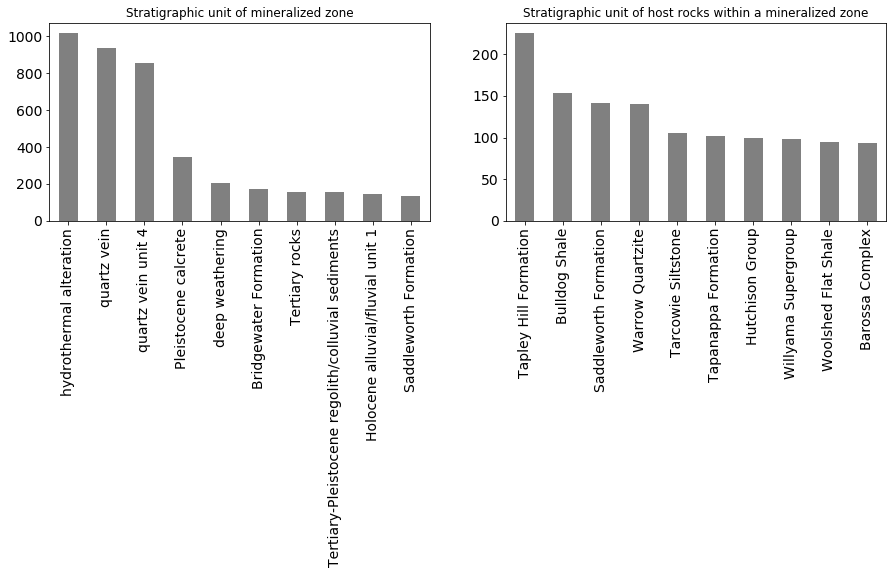

In [48]:
# Stratigraphic unit of mineralized zone
plt.figure(figsize=(15,16))
plt.subplot(221)
md_zone_lith['HR_STRAT_UNIT'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='gray', rot=90, fontsize=14)
plt.title('Stratigraphic unit of mineralized zone')

# Stratigraphic unit of host rocks within a mineralized zone
plt.subplot(222)
md_zone_hr_lith['HR_STRAT_UNIT'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='gray', rot=90, fontsize=14)
plt.title('Stratigraphic unit of host rocks within a mineralized zone')

plt.show()